In [2]:
import numpy as np
import numpy.random as R
import math
import matplotlib.pyplot as plt

import global_as

epsilon = 0.001
def dFunc(x):
    chi = x.shape[0]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

In [3]:
#lower and upper parameter bounds
lb_L = np.array([30, 0.005, 0.002, 1000, 90000, 290, 340])
ub_L = np.array([60, 0.020, 0.010, 5000, 110000, 296, 360])

def Func(x1):      
    x = lb_L + x1*(ub_L-lb_L)
    M, S, V0, k, P0, Ta, T0 = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6]
    A = P0*S + 19.62*M - k*V0/S
    V = S/2/k*(np.sqrt(A**2+4*k*P0*V0*Ta/T0)-A)
    return 2*math.pi*np.sqrt(M/(k+S**2*P0*V0*Ta/T0/V**2))

#labels for plots
in_labels = [r'$M$', r'$S$', r'$V_0$', r'$k$', r'$P_0$',r'$T_a$', r'$T_0$']

In [4]:
### Activity scores
dim = 7
chi = 10000

z = R.uniform(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.sqrt(chi)
u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=True)   
s0 = s0**2

print('Cumulative explained variance (first 10):',(np.cumsum(s0)/np.sum(s0))[:10])
print('The 1st eigenvector (first 10):',u0[:10,0])

Cumulative explained variance (first 10): [0.87740226 0.96987629 0.99575767 0.99989765 0.99998694 1.
 1.        ]
The 1st eigenvector (first 10): [-0.16019988  0.79411    -0.57552314  0.1075146   0.03033383 -0.00146512
  0.00409139]


In [5]:
### Global activity scores
u, s = global_as.GAS(Func,dim,chi,10000,1,shiftedSobol=True, distribution = 'uniform') 
print('Cumulative explained variance (first 10):',(np.cumsum(s)/np.sum(s))[:10])
print('The 1st eigenvector (first 10):',u[:10,0])

Cumulative explained variance (first 10): [0.91167644 0.97295333 0.99548862 0.9999042  0.99998237 1.
 1.        ]
The 1st eigenvector (first 10): [-0.19417648  0.77619366 -0.57713308  0.15948961  0.03563457 -0.00183346
  0.0051164 ]


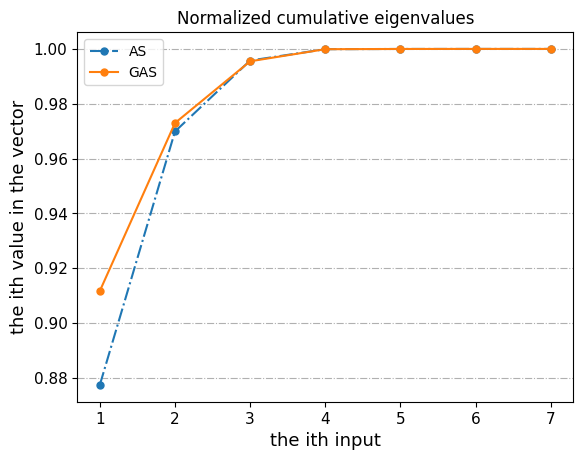

In [6]:
### Eigenvalues
x=np.arange(1,1+len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,np.cumsum(s0)/np.sum(s0), label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,np.cumsum(s)/np.sum(s), label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Normalized cumulative eigenvalues') 
plt.savefig('gascore_paper/pistonE1.png')

/var/folders/3g/94n8wq0x2173q3pr5zt6vy940000gq/T/ipykernel_5167/1374611451.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['d']+in_labels)


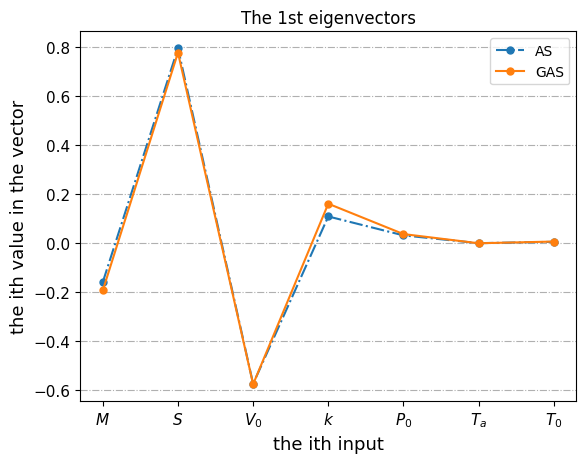

In [7]:
### Eigenvectors
x=np.arange(0,len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,u0[:,0], label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,u[:,0], label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.set_xticklabels(['d']+in_labels)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('The 1st eigenvectors') 
plt.savefig('gascore_paper/pistonE2.png')

In [8]:
### Sobol' indices
sample_list = []
for i in range(10):
    z3 = R.uniform(0, 1, (100000, dim))
    sample_list.append(np.mean(Func(z3)))
sample_list = sum(sample_list)/len(sample_list)
sigma2 = sum((Func(R.uniform(0, 1, (100000, dim))) - sample_list)**2)/100000
sigma2
chi = 10000
x, z, w = R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim))
upper, lower = [], []
for i in range(dim):
    fx, fz = Func(x), Func(z)
    x_uz, z_ux, w_ux = z.copy(), x.copy(), x.copy()
    x_uz[:,i], z_ux[:,i], w_ux[:,i] = x[:,i], z[:,i], w[:,i]
    upper.append(0.5*sum((fx - Func(z_ux))**2)/chi/sigma2)
    lower.append(sum((Func(x_uz) - fz)*(fx - Func(w_ux)))/chi/sigma2)

In [9]:
print('Total sensitivity indices',' & '.join(str(i) for i in upper))
dgsm = np.round(u0[:,:]**2@s0[:]/sum(u0[:,:]**2@s0[:]),4)
print('DGSM',' & '.join(str(i) for i in dgsm))
d1=2
as_scores = np.round(u0[:,:d1]**2@s0[:d1]/sum(u0[:,:d1]**2@s0[:d1]),4)
print('Active scores',' & '.join(str(i) for i in as_scores))
d1=1
gas_scores = np.round(u[:,:d1]**2@s[:d1]/sum(u[:,:d1]**2@s[:d1]),4)
print('Global active scores',' & '.join(str(i) for i in gas_scores))
gas_full = np.round(u[:,:]**2@s[:]/sum(u[:,:]**2@s[:]),4)
print('Global active scores',' & '.join(str(i) for i in gas_full))

Total sensitivity indices 0.05038248178337067 & 0.6162980620583237 & 0.3541948753454012 & 0.06582263514001677 & 0.0013597344382906187 & 8.876798732153847e-06 & 7.182514689604817e-05
DGSM 0.04 & 0.57 & 0.3361 & 0.0529 & 0.001 & 0.0 & 0.0001
Active scores 0.0332 & 0.5807 & 0.3404 & 0.0449 & 0.0008 & 0.0 & 0.0
Global active scores 0.0377 & 0.6025 & 0.3331 & 0.0254 & 0.0013 & 0.0 & 0.0
Global active scores 0.0478 & 0.5584 & 0.3279 & 0.0645 & 0.0013 & 0.0 & 0.0001


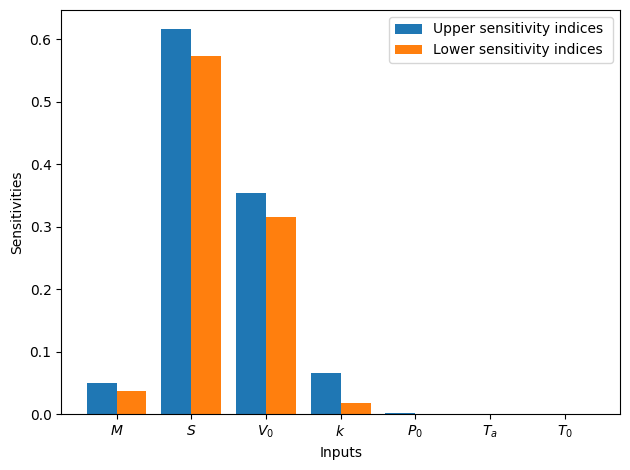

In [10]:
### Sobol' indices
width = 0.4
x = np.arange(1,8)
labels = x
fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, upper, width, label='Upper sensitivity indices')
rects2 = ax.bar(x+width/2, lower, width, label='Lower sensitivity indices ')
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.set_xticklabels(in_labels)
ax.legend(loc='upper right')

fig.tight_layout()
plt.savefig('gascore_paper/pistonSA1.png')

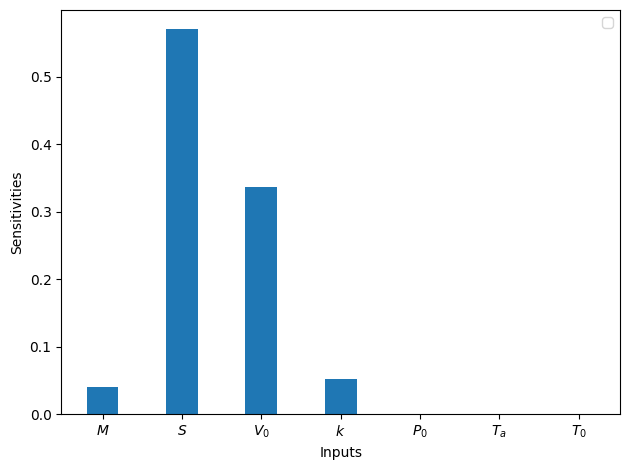

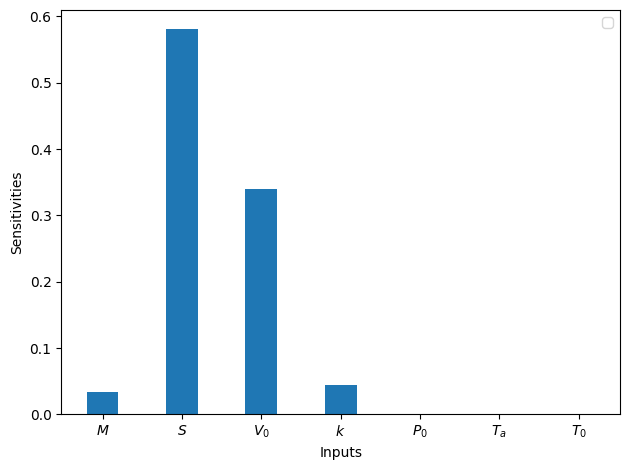

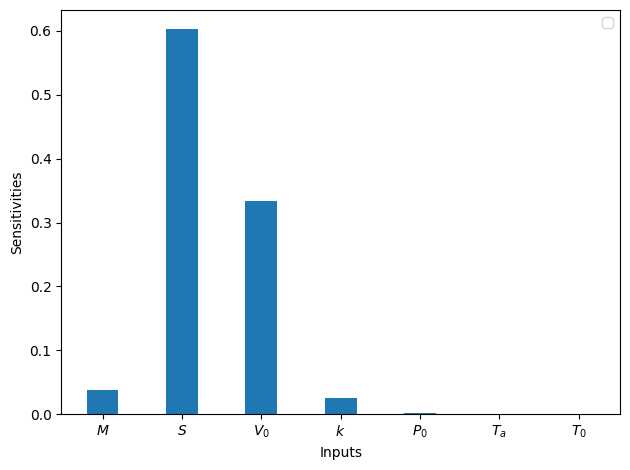

In [11]:
### Other scores
fig, ax = plt.subplots()
rects1 = ax.bar(x, dgsm, width)
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.set_xticklabels(in_labels)
ax.legend()

fig.tight_layout()
plt.savefig('gascore_paper/pistonSA2.png')

fig, ax = plt.subplots()
rects1 = ax.bar(x, as_scores, width)
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.set_xticklabels(in_labels)
ax.legend()

fig.tight_layout()
plt.savefig('gascore_paper/pistonSA3.png')

fig, ax = plt.subplots()
rects1 = ax.bar(x, gas_scores, width)
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.set_xticklabels(in_labels)
ax.legend()

fig.tight_layout()
plt.savefig('gascore_paper/pistonSA4.png')

In [12]:
as_scores,gas_scores = [],[]
Nlist = [1,2,3,4,5,6,7]
for d1 in Nlist:
    as_scores.append(u0[:,:d1]**2@s0[:d1]/sum(u0[:,:d1]**2@s0[:d1]))
    gas_scores.append(u[:,:d1]**2@s[:d1]/sum(u[:,:d1]**2@s[:d1]))
as_scores = np.array(as_scores)
gas_scores = np.array(gas_scores)

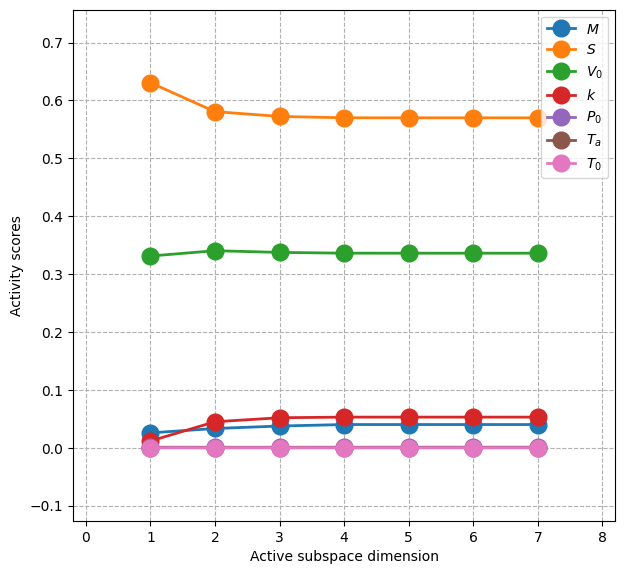

In [13]:
plt.figure(figsize=(7,7))
plt.rc('font')
for i in range(dim):
    plt.plot(np.array(Nlist), as_scores[:,i], 'o-', markersize=12,linewidth=2,clip_on=False,label = in_labels[i])
plt.xlabel('Active subspace dimension')
plt.ylabel('Activity scores')
plt.grid(True,linestyle = '--')
plt.legend()
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.savefig('gascore_paper/piston_change.png')

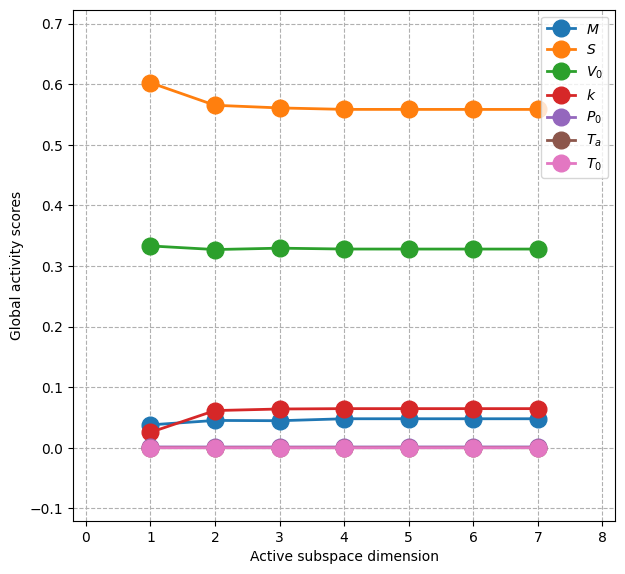

In [14]:
plt.figure(figsize=(7,7))
plt.rc('font')
for i in range(dim):
    plt.plot(np.array(Nlist), gas_scores[:,i], 'o-', markersize=12,linewidth=2,clip_on=False,label = in_labels[i])
plt.xlabel('Active subspace dimension')
plt.ylabel('Global activity scores')
plt.grid(True,linestyle = '--')
plt.legend()
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.savefig('gascore_paper/piston_change2.png')